In [1]:
import numpy as np
from numpy import random

In [2]:
import pandas as pd

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import math

In [5]:
from scipy.stats import bernoulli

# Functions

In [6]:
def remaining_jobs(remaining_service_times):
    return [[j for j in range(N_list[i]) if remaining_service_times[i][j] >= 1] for i in range(I)]

def remaining_classes(jobs):
    return [i for i in range(I) if np.array(jobs[i]).size >= 1]

def holding_cost(mean_values, jobs):
    return np.sum([mean_values[i]*np.array(jobs[i]).size for i in range(I)])

In [7]:
def update_num_data(num_data, jobs, classes):
    for i in classes:
        num_data[i] += np.array(jobs[i]).size

def update_costs_by_classes(t, jobs, classes, costs_by_classes):
    for i in classes:
        for j in jobs[i]:
            costs_by_classes[i] += samples[i][j][t]

In [8]:
def select_by_means(num_data, costs_by_classes, classes):
    empirical_means = costs_by_classes[classes] / num_data[classes]
    return classes[np.argmax(empirical_means)]

def serve(i, remaining_service_times, jobs):
    remaining_service_times[i][jobs[i][0]] -= 1
    
def complete(i, remaining_service_times, jobs):
    remaining_service_times[i][jobs[i][0]] = 0

In [9]:
def minimum_cost(mean_values):
    classes_sorted = np.argsort(-mean_values)
    total_cost = 0
    count = S
    for i in range(I):
        class_i = classes_sorted[i]
        for j in range(N_list[class_i]):
            total_cost += count*mean_values[class_i]
            count += S
    return total_cost

In [10]:
def preempt_then_nonpreempt(mean_values, samples):
    tau = math.floor( (S**(2/3)) * ((np.log(N*S))**(1/3)) / (min(N_list)**(1/3)))
    remaining_service_times = [[S for j in range(N_list[i])] for i in range(I)]
    jobs = [[j for j in range(N_list[i]) if remaining_service_times[i][j] >= 1] for i in range(I)]
    classes = [i for i in range(I)]
    total_holding_cost = 0
    designated_class = -1
    
    num_data, costs_by_classes = np.zeros(I), np.zeros(I)
    
    for t in range(N*S):
        total_holding_cost += holding_cost(mean_values, jobs)
        update_num_data(num_data, jobs, classes)
        update_costs_by_classes(t, jobs, classes, costs_by_classes)
        if (t <= tau) or (designated_class == -1):
            designated_class = select_by_means(num_data, costs_by_classes, classes)
        
        serve(designated_class, remaining_service_times, jobs)
        if remaining_service_times[designated_class][jobs[designated_class][0]] == 0:
            jobs = remaining_jobs(remaining_service_times)
            #print(designated_class, jobs)
            if np.array(jobs[designated_class]).size == 0:
                classes = np.setdiff1d(classes, [designated_class])
            designated_class = -1
    return total_holding_cost

In [11]:
def update_conf_radius(num_data, conf_radius, classes):
    for i in classes:
        conf_radius[i] = math.sqrt(3 * np.log(N*S) / num_data[i])
        
def update_priority_classes(num_data, costs_by_classes, conf_radius, classes, priority_classes):
    p_classes = np.array(np.append(priority_classes, np.argmax(N_list)), int)
    np_classes = np.setdiff1d(classes, p_classes)
    LCB_values = costs_by_classes[np_classes] / num_data[np_classes] - conf_radius[np_classes]
    UCB_values = costs_by_classes[p_classes] / num_data[p_classes] + conf_radius[p_classes]
    priority_classes_new = priority_classes
    for i in range(np.array(LCB_values).size):
        if LCB_values[i] > np.min(UCB_values):
            priority_classes_new = np.array(np.append(priority_classes_new, np_classes[i]), int)
    return priority_classes_new

In [12]:
def preempt_then_nonpreempt_refined(mean_values, samples):
    tau = math.floor( (S**(2/3)) * ((np.log(N*S))**(1/3)) / (min(N_list)**(1/3)))
    remaining_service_times = [[S for j in range(N_list[i])] for i in range(I)]
    jobs = [[j for j in range(N_list[i]) if remaining_service_times[i][j] >= 1] for i in range(I)]
    classes = [i for i in range(I)]
    
    priority_classes = []
    i_max = np.argmax(N_list)
    
    total_holding_cost = 0
    designated_class = -1
    
    num_data, costs_by_classes, conf_radius = np.zeros(I), np.zeros(I), np.zeros(I)
    for t in range(N*S):
        total_holding_cost += holding_cost(mean_values, jobs)
        update_num_data(num_data, jobs, classes)
        update_costs_by_classes(t, jobs, classes, costs_by_classes)
        
        if (t <= tau) or (designated_class == -1):
            if np.array(jobs[i_max]).size == 0:
                designated_class = select_by_means(num_data, costs_by_classes, classes)
            else:
                update_conf_radius(num_data, conf_radius, classes)
                priority_classes = update_priority_classes(num_data, costs_by_classes, conf_radius, classes, priority_classes)
                if np.array(priority_classes).size >= 1:
                    designated_class = select_by_means(num_data, costs_by_classes, priority_classes)
                else:
                    designated_class = i_max
        
        serve(designated_class, remaining_service_times, jobs)
        if remaining_service_times[designated_class][jobs[designated_class][0]] == 0:
            jobs = remaining_jobs(remaining_service_times)
            #print(designated_class, jobs)
            if np.array(jobs[designated_class]).size == 0:
                classes = np.setdiff1d(classes, [designated_class])
            if np.array(jobs[i_max]).size >= 1:
                priority_classes = np.setdiff1d(priority_classes, [designated_class])
            designated_class = -1
    return total_holding_cost

# Running experiments

- $I$ is the number of classes
- $N$ is the number of jobs
- $S$ is the service time of each job, counted as the number of required time steps
- $\tau$ is set to $$\tau=\lfloor N_{\min}^{-1/3}S^{2/3}\log NS\rfloor.$$

In [13]:
I = 2
N_max_list_1 = [10,20,30,40,50,60,70,80,90,100]
N_max_list_2 = [110,120,130,140,150,160,170,180,190,200]
S = 100

## Creating an output file

In [14]:
def create_output_files():
    column_labels = ['N_max', 'type', 'service_time', 'eps', 'instance_number', 'OPT', 
                     'original', 'refined']
    df = pd.DataFrame(columns=column_labels)
    df.to_csv('results_raw_data_uniform.csv', index=False)

In [15]:
#create_output_files()

## Sampling mean holding costs

- We sample $c_1,\ldots,c_I$ from $[0.5-\epsilon, 0.5+\epsilon]$ while varying the size of $\epsilon$.

In [16]:
eps_list = np.array([0.001*(i+1) for i in range(10)])

## Deterministic cost function vs Stochastic function

In [36]:
T_total = 50
mean_cost = 0.5

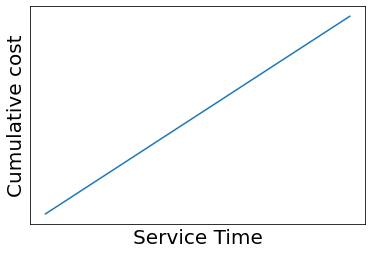

In [39]:
time_steps = range(T_total)
deterministic_cumulative_costs = [mean_cost*i for i in time_steps]
sns.lineplot(x=time_steps, y=deterministic_cumulative_costs)
plt.xlabel("Service Time", fontsize=20)
plt.ylabel("Cumulative cost", fontsize=20)
plt.xticks([])
plt.yticks([])
plt.savefig('det_cost.pdf', bbox_inches = 'tight')

<AxesSubplot:>

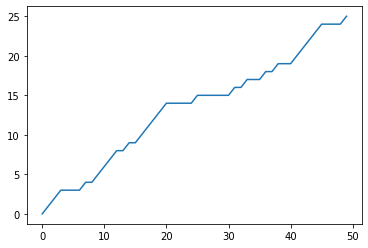

In [38]:
time_steps = range(T_total)
samples = bernoulli.rvs(mean_cost, size=T_total)
stochastic_cumulative_costs = [np.sum(samples[0:i+1]) for i in time_steps]
sns.lineplot(x=time_steps, y=stochastic_cumulative_costs)

In [27]:
mean_cost

0.5

In [28]:
samples

array([1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1,
       0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0,
       1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0])

## Drawing plots

### Regret

The regret value of an algorithm is defined as follows:
$$\text{Regret = the total holding cost of the algorithm - the minimum holding cost (OPT)}.$$

We compare two different algorithms:
- original: empirical $c\mu$ rule with preemption then nonpreemption
- refined: the refined version of "original" to consider unbalanced cases

### The first setting

The mean holding cost of each class is sampled from the uniform distribution over $[0.5-\epsilon, 0.5+\epsilon]$ (interval).

#### Performance of the refined algorithm; comparison between the "unbalanced" case and the "balanced" case

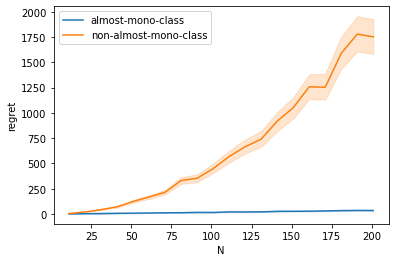

In [15]:
# N = 10, 20, ..., 180, 190, 200
# eps = 0.001, 0.002, ..., 0.009, 0.01
# 100 test for each case

df = pd.read_csv('results_raw_data_uniform.csv')
type_1 = (df['type'] == 1) & (df['N_max'] <= 200) & (df['N_max'] >= 10) & (df['eps'] > 0.0001) & (df['eps'] <= 0.01)
type_3 = (df['type'] == 3) & (df['N_max'] <= 200) & (df['N_max'] >= 10) & (df['eps'] > 0.0001) & (df['eps'] <= 0.01)
filtered_1 = df[type_1]
filtered_3 = df[type_3]
sns.lineplot(x=filtered_1['N_max']+1, y=filtered_1['refined'], label='almost-mono-class')
sns.lineplot(x=filtered_3['N_max']+1, y=filtered_3['refined'], label='non-almost-mono-class')
plt.xlabel("N")
plt.ylabel("regret")
plt.legend()

#### Unbalanced case; comparison between "original" vs "refined"

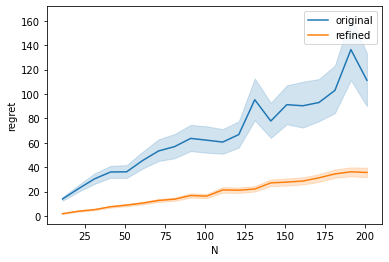

In [44]:
# N = 10, 20, ..., 180, 190,200
# eps = 0.001, 0.002, ..., 0.009, 0.01
# 100 test for each case

df = pd.read_csv('results_raw_data_uniform.csv')
filt = (df['type'] == 1) & (df['N_max'] <= 200) & (df['N_max'] >= 10) & (df['eps'] > 0.0001) & (df['eps'] <= 0.01)
filtered = df[filt]
sns.lineplot(x=filtered['N_max']+1, y=filtered['original'], label='original')
sns.lineplot(x=filtered['N_max']+1, y=filtered['refined'], label='refined')
plt.xlabel("N")
plt.ylabel("regret")
plt.legend()

#### Balanced case; comparison between "original" and "refined"

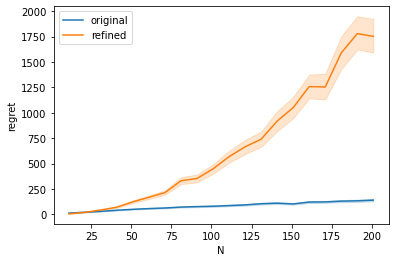

In [45]:
# N = 10, 20, ..., 180, 190, 200
# eps = 0.001, 0.002, ..., 0.009, 0.01
# 100 test for each case

df = pd.read_csv('results_raw_data_uniform.csv')
filt = (df['type'] == 3) & (df['N_max'] <= 200) & (df['N_max'] >= 10) & (df['eps'] > 0.0001) & (df['eps'] <= 0.01)
filtered = df[filt]
sns.lineplot(x=filtered['N_max']+1, y=filtered['original'], label='original')
sns.lineplot(x=filtered['N_max']+1, y=filtered['refined'], label='refined')
plt.xlabel("N")
plt.ylabel("regret")
plt.legend()

### The second setting

The mean holding cost of each class is sampled from the uniform distribution over $\{0.5-\epsilon, 0.5+\epsilon\}$ (only two values).

#### Performance of the refined algorithm; comparison between the "unbalanced" case and the "balanced" case

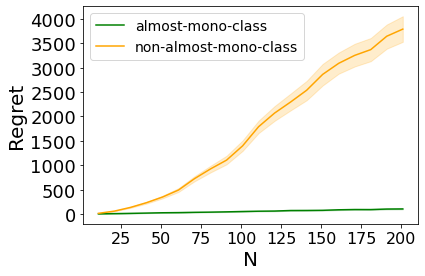

In [14]:
# comparison between the unbalanced case and the balanced case; the refined algorithm
# N = 10, 20, ..., 180, 190, 200
# eps = 0.001, 0.002, ..., 0.009, 0.01
# 100 test for each case

df = pd.read_csv('results_raw_data_uniform.csv')
type_1 = (df['type'] == 4) & (df['N_max'] <= 200) & (df['N_max'] >= 10) & (df['eps'] > 0.0001) & (df['eps'] <= 0.01)
type_3 = (df['type'] == 5) & (df['N_max'] <= 200) & (df['N_max'] >= 10) & (df['eps'] > 0.0001) & (df['eps'] <= 0.01)
filtered_1 = df[type_1]
filtered_3 = df[type_3]
sns.lineplot(x=filtered_1['N_max']+1, y=filtered_1['refined'], label='almost-mono-class', color='green')
sns.lineplot(x=filtered_3['N_max']+1, y=filtered_3['refined'], label='non-almost-mono-class', color='orange')
plt.xlabel("N", fontsize=20)
plt.ylabel("Regret", fontsize=20)
plt.legend(fontsize=14)
plt.xticks(fontsize=16)
plt.yticks(fontsize=18)
plt.savefig('refined_algo.pdf', bbox_inches = 'tight')

#### Unbalanced case; comparison between "original" vs "refined"

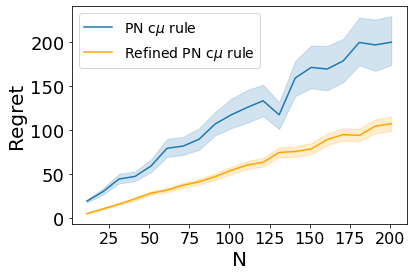

In [8]:
# N = 10, 20, ..., 180, 190, 200
# eps = 0.001, 0.002, ..., 0.009, 0.01
# 100 test for each case

df = pd.read_csv('results_raw_data_uniform.csv')
filt = (df['type'] == 4) & (df['N_max'] <= 200) & (df['N_max'] >= 10) & (df['eps'] > 0.0001) & (df['eps'] <= 0.01)
filtered = df[filt]
sns.lineplot(x=filtered['N_max']+1, y=filtered['original'], label='PN c$\mu$ rule')
sns.lineplot(x=filtered['N_max']+1, y=filtered['refined'], label='Refined PN c$\mu$ rule', color='orange')
plt.xlabel("N", fontsize=20)
plt.ylabel("Regret", fontsize=20)
plt.legend(fontsize=14)
plt.xticks(fontsize=16)
plt.yticks(fontsize=18)
plt.savefig('refined_original.pdf', bbox_inches = 'tight')

#### Balanced case; comparison between "original" and "refined"

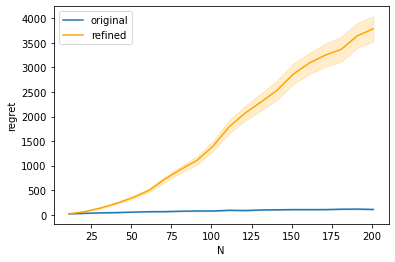

In [58]:
# N = 10, 20, ..., 180, 190, 200
# eps = 0.001, 0.002, ..., 0.009, 0.01
# 100 test for each case

df = pd.read_csv('results_raw_data_uniform.csv')
filt = (df['type'] == 5) & (df['N_max'] <= 200) & (df['N_max'] >= 10) & (df['eps'] > 0.0001) & (df['eps'] <= 0.01)
filtered = df[filt]
sns.lineplot(x=filtered['N_max']+1, y=filtered['original'], label='original')
sns.lineplot(x=filtered['N_max']+1, y=filtered['refined'], label='refined', color='orange')
plt.xlabel("N")
plt.ylabel("regret")
plt.legend()

#### Relative regret for Balanced case; comparison between "original" and "refined"

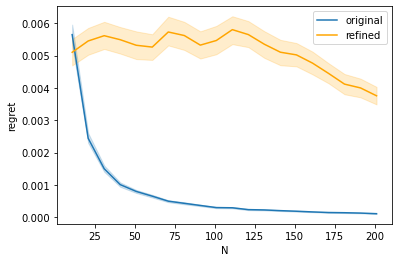

In [57]:
# N = 10, 20, ..., 180, 190, 200
# eps = 0.001, 0.002, ..., 0.009, 0.01
# 100 test for each case

df = pd.read_csv('results_raw_data_uniform.csv')
filt = (df['type'] == 5) & (df['N_max'] <= 200) & (df['N_max'] >= 10) & (df['eps'] > 0.0001) & (df['eps'] <= 0.01)
filtered = df[filt]
sns.lineplot(x=filtered['N_max']+1, y=(filtered['original'])/(filtered['OPT']), label='original')
sns.lineplot(x=filtered['N_max']+1, y=(filtered['refined'])/(filtered['OPT']), label='refined', color='orange')
plt.xlabel("N")
plt.ylabel("regret")
plt.legend()

## Testing instances with mean $0.5\pm \epsilon$

## Testing different values of $\epsilon$

- it_num: the number of randomly generated instances we test for each value of $\epsilon$.

In [101]:
# unbalanced case; 100 <= N_max <= 200

it_num = 100
I = 2

for eps in eps_list:
    for N_max in N_max_list_2:
        N = N_max + 1
        N_list = [N_max, 1]
        
        for i in range(it_num):
            mean_values = np.zeros(2)
            coin_flip = bernoulli.rvs(0.5,size=1)[0]
            mean_values[0] = 0.5 + (1-2*coin_flip)*eps
            mean_values[1] = 1 - mean_values[0]
            samples = [[bernoulli.rvs(mean_values[i], size=N*S) for j in range(N_list[i])] for i in range(I)]
        
            OPT = minimum_cost(mean_values)
            original = preempt_then_nonpreempt(mean_values, samples) - OPT
            refined = preempt_then_nonpreempt_refined(mean_values, samples) - OPT

            df = pd.read_csv('results_raw_data_uniform.csv')
            df = df.append({'N_max': N_max, 'type': 4, 'service_time': S, 'eps': eps, 'instance_number': i+1, 'OPT': OPT, 
                            'original': original, 'refined': refined}, ignore_index = True)
            df.to_csv('results_raw_data_uniform.csv', index=False)

In [99]:
# unbalanced case; 10 <= N_max <= 100

it_num = 100
I = 2

for eps in eps_list:
    for N_max in N_max_list_1:
        N = N_max + 1
        N_list = [N_max, 1]
        
        for i in range(it_num):
            mean_values = np.zeros(2)
            coin_flip = bernoulli.rvs(0.5,size=1)[0]
            mean_values[0] = 0.5 + (1-2*coin_flip)*eps
            mean_values[1] = 1 - mean_values[0]
            samples = [[bernoulli.rvs(mean_values[i], size=N*S) for j in range(N_list[i])] for i in range(I)]
        
            OPT = minimum_cost(mean_values)
            original = preempt_then_nonpreempt(mean_values, samples) - OPT
            refined = preempt_then_nonpreempt_refined(mean_values, samples) - OPT

            df = pd.read_csv('results_raw_data_uniform.csv')
            df = df.append({'N_max': N_max, 'type': 4, 'service_time': S, 'eps': eps, 'instance_number': i+1, 'OPT': OPT, 
                            'original': original, 'refined': refined}, ignore_index = True)
            df.to_csv('results_raw_data_uniform.csv', index=False)

tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
t

tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
t

tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
t

tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
t

tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
t

tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
t

tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
t

tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
t

tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
t

tau:  42
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
t

tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
t

In [102]:
# balanced case; 10 <= N_max <= 100

it_num = 100
I = 2

for eps in eps_list:
    for N_max in N_max_list_1:
        N = N_max + 1
        N_2 = math.floor(N/2)
        N_list = [N-N_2, N_2]
        
        for i in range(it_num):
            mean_values = np.zeros(2)
            coin_flip = bernoulli.rvs(0.5,size=1)[0]
            mean_values[0] = 0.5 + (1-2*coin_flip)*eps
            mean_values[1] = 1 - mean_values[0]
            samples = [[bernoulli.rvs(mean_values[i], size=N*S) for j in range(N_list[i])] for i in range(I)]
        
            OPT = minimum_cost(mean_values)
            original = preempt_then_nonpreempt(mean_values, samples) - OPT
            refined = preempt_then_nonpreempt_refined(mean_values, samples) - OPT

            df = pd.read_csv('results_raw_data_uniform.csv')
            df = df.append({'N_max': N_max, 'type': 5, 'service_time': S, 'eps': eps, 'instance_number': i+1, 'OPT': OPT, 
                            'original': original, 'refined': refined}, ignore_index = True)
            df.to_csv('results_raw_data_uniform.csv', index=False)

In [103]:
# balanced case; 110 <= N_max <= 200

it_num = 100
I = 2

for eps in eps_list:
    for N_max in N_max_list_2:
        N = N_max + 1
        N_2 = math.floor(N/2)
        N_list = [N-N_2, N_2]
        
        for i in range(it_num):
            mean_values = np.zeros(2)
            coin_flip = bernoulli.rvs(0.5,size=1)[0]
            mean_values[0] = 0.5 + (1-2*coin_flip)*eps
            mean_values[1] = 1 - mean_values[0]
            samples = [[bernoulli.rvs(mean_values[i], size=N*S) for j in range(N_list[i])] for i in range(I)]
        
            OPT = minimum_cost(mean_values)
            original = preempt_then_nonpreempt(mean_values, samples) - OPT
            refined = preempt_then_nonpreempt_refined(mean_values, samples) - OPT

            df = pd.read_csv('results_raw_data_uniform.csv')
            df = df.append({'N_max': N_max, 'type': 5, 'service_time': S, 'eps': eps, 'instance_number': i+1, 'OPT': OPT, 
                            'original': original, 'refined': refined}, ignore_index = True)
            df.to_csv('results_raw_data_uniform.csv', index=False)

In [19]:
# unbalanced case; 100 tests done for small N; 30 tests done for large N; need to run 70 more tests for large N

it_num = 100
I = 2

for eps in eps_list:
    for N_max in N_max_list_1:
        N = N_max + 1
        N_list = [N_max, 1]
        
        for i in range(it_num):
            mean_values = np.zeros(2)
            coin_flip = bernoulli.rvs(0.5,size=1)[0]
            mean_values[0] = 0.5 + (1-2*coin_flip)*eps
            mean_values[1] = 1 - mean_values[0]
            samples = [[bernoulli.rvs(mean_values[i], size=N*S) for j in range(N_list[i])] for i in range(I)]
        
            OPT = minimum_cost(mean_values)
            original = preempt_then_nonpreempt(mean_values, samples) - OPT
            refined = preempt_then_nonpreempt_refined(mean_values, samples) - OPT

            df = pd.read_csv('results_raw_data_uniform.csv')
            df = df.append({'N_max': N_max, 'type': 1, 'service_time': S, 'eps': eps, 'instance_number': i+1, 'OPT': OPT, 
                            'original': original, 'refined': refined}, ignore_index = True)
            df.to_csv('results_raw_data_uniform.csv', index=False)

tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
t

tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
t

tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
t

tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
t

tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
t

tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
t

tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
tau:  42
t

tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
t

tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
tau:  43
t

tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
t

tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
t

tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
t

tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
t

tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
t

tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
tau:  41
t

tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
tau:  44
t

In [50]:
# unbalanced case; 100 tests done for small N; 30 tests done for large N; need to run 70 more tests for large N

it_num = 100
I = 2

for eps in np.array([0.001*(i+1) for i in range(9)]):
    for N_max in [110,120,130,140,150,160,170,180,190]:
        N = N_max + 1
        N_list = [N_max, 1]
        
        for i in range(it_num):
            mean_values = np.random.uniform(0.5-eps, 0.5+eps, I)
            samples = [[bernoulli.rvs(mean_values[i], size=N*S) for j in range(N_list[i])] for i in range(I)]
        
            OPT = minimum_cost(mean_values)
            original = preempt_then_nonpreempt(mean_values, samples) - OPT
            refined = preempt_then_nonpreempt_refined(mean_values, samples) - OPT

            df = pd.read_csv('results_raw_data_uniform.csv')
            df = df.append({'N_max': N_max, 'type': 1, 'service_time': S, 'eps': eps, 'instance_number': i+1, 'OPT': OPT, 
                            'original': original, 'refined': refined}, ignore_index = True)
            df.to_csv('results_raw_data_uniform.csv', index=False)

tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
t

tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
t

tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
t

tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
t

tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
t

tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
t

tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
t

tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
t

tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
t

tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
t

tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
t

tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
t

tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
t

tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
t

tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
t

tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
t

tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
t

tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
tau:  45
t

In [49]:
# unbalanced case; 100 tests done for small N; 30 tests done for large N; need to run 70 more tests for large N

it_num = 70
I = 2

for eps in np.array([0.001*(i+1) for i in range(9)]):
    for N_max in N_max_list_3:
        N = N_max + 1
        N_list = [N_max, 1]
        
        for i in range(it_num):
            mean_values = np.random.uniform(0.5-eps, 0.5+eps, I)
            samples = [[bernoulli.rvs(mean_values[i], size=N*S) for j in range(N_list[i])] for i in range(I)]
        
            OPT = minimum_cost(mean_values)
            original = preempt_then_nonpreempt(mean_values, samples) - OPT
            refined = preempt_then_nonpreempt_refined(mean_values, samples) - OPT

            df = pd.read_csv('results_raw_data_uniform.csv')
            df = df.append({'N_max': N_max, 'type': 1, 'service_time': S, 'eps': eps, 'instance_number': i+31, 'OPT': OPT, 
                            'original': original, 'refined': refined}, ignore_index = True)
            df.to_csv('results_raw_data_uniform.csv', index=False)

tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
t

tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
tau:  46
t

In [17]:
# balanced case, 2 classes; 100 tests done for small N; no test done for large N

it_num = 70
I = 2

for eps in eps_list:
    for N_max in N_max_list_1:
        N = N_max + 1
        N_2 = math.floor(N/2)
        N_list = [N-N_2, N_2]
        
        for i in range(it_num):
            mean_values = np.random.uniform(0.5-eps, 0.5+eps, I)
            samples = [[bernoulli.rvs(mean_values[i], size=N*S) for j in range(N_list[i])] for i in range(I)]
        
            OPT = minimum_cost(mean_values)
            original = preempt_then_nonpreempt(mean_values, samples) - OPT
            refined = preempt_then_nonpreempt_refined(mean_values, samples) - OPT

            df = pd.read_csv('results_raw_data_uniform.csv')
            df = df.append({'N_max': N_max, 'type': 3, 'service_time': S, 'eps': eps, 'instance_number': i+31, 'OPT': OPT, 
                            'original': original, 'refined': refined}, ignore_index = True)
            df.to_csv('results_raw_data_uniform.csv', index=False)

tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
t

tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
t

tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
t

tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
t

tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
t

tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
t

tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
t

tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
tau:  19
t

tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
t

tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
tau:  16
t

tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
t

tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
tau:  14
t

tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
t

tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
t

tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
tau:  17
t

tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
tau:  12
t

tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
tau:  15
t

tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  37
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
tau:  24
t

tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
tau:  13
t

In [48]:
# balanced case, 2 classes; 100 tests done for small N; no test done for large N

it_num = 100
I = 2

for eps in np.array([0.001*(i+1) for i in range(9)]):
    for N_max in N_max_list_2:
        N = N_max + 1
        N_2 = math.floor(N/2)
        N_list = [N-N_2, N_2]
        
        for i in range(it_num):
            mean_values = np.random.uniform(0.5-eps, 0.5+eps, I)
            samples = [[bernoulli.rvs(mean_values[i], size=N*S) for j in range(N_list[i])] for i in range(I)]
        
            OPT = minimum_cost(mean_values)
            original = preempt_then_nonpreempt(mean_values, samples) - OPT
            refined = preempt_then_nonpreempt_refined(mean_values, samples) - OPT

            df = pd.read_csv('results_raw_data_uniform.csv')
            df = df.append({'N_max': N_max, 'type': 3, 'service_time': S, 'eps': eps, 'instance_number': i+1, 'OPT': OPT, 
                            'original': original, 'refined': refined}, ignore_index = True)
            df.to_csv('results_raw_data_uniform.csv', index=False)

tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
t

tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
t

tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9


tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
t

tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
t

tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
t

tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
t

tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
t

tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
t

tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
t

tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
t

tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
t

tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
t

tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau

tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
t

tau:  10
tau:  10
tau:  10
tau:  10
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:

tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
t

tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
t

tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
tau:  11
t

tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
tau:  10
t

In [47]:
# balanced case, 2 classes; 100 tests done for small N; no test done for large N

it_num = 30
I = 2

for eps in np.array([0.01]):
    for N_max in N_max_list_3:
        N = N_max + 1
        N_2 = math.floor(N/2)
        N_list = [N-N_2, N_2]
        
        for i in range(it_num):
            mean_values = np.random.uniform(0.5-eps, 0.5+eps, I)
            samples = [[bernoulli.rvs(mean_values[i], size=N*S) for j in range(N_list[i])] for i in range(I)]
        
            OPT = minimum_cost(mean_values)
            original = preempt_then_nonpreempt(mean_values, samples) - OPT
            refined = preempt_then_nonpreempt_refined(mean_values, samples) - OPT

            df = pd.read_csv('results_raw_data_uniform.csv')
            df = df.append({'N_max': N_max, 'type': 3, 'service_time': S, 'eps': eps, 'instance_number': i+1, 'OPT': OPT, 
                            'original': original, 'refined': refined}, ignore_index = True)
            df.to_csv('results_raw_data_uniform.csv', index=False)

tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9
tau:  9


# balanced case, 10 classes; no test done for small N; no test done for large N

it_num = 100
I = 10

for eps in eps_list:
    for N_max in N_max_list:
        N = I*N_max
        N_list = [N_max, N_max, N_max, N_max, N_max, N_max, N_max, N_max, N_max, N_max]
        
        for i in range(it_num):
            mean_values = np.random.uniform(0.5-eps, 0.5+eps, I)
            samples = [[bernoulli.rvs(mean_values[i], size=N*S) for j in range(N_list[i])] for i in range(I)]
        
            OPT = minimum_cost(mean_values)
            original = preempt_then_nonpreempt(mean_values, samples) - OPT
            refined = preempt_then_nonpreempt_refined(mean_values, samples) - OPT

            df = pd.read_csv('results_raw_data_uniform.csv')
            df = df.append({'N_max': N_max, 'type': 3, 'service_time': S, 'eps': eps, 'instance_number': i+1, 'OPT': OPT, 
                            'original': original, 'refined': refined}, ignore_index = True)
            df.to_csv('results_raw_data_uniform.csv', index=False)